<a href="https://colab.research.google.com/github/MohamedAziz15/Text-Classification-AWS/blob/main/text_classification_aws.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install huggingface-hub

In [2]:
!pip install datasets

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.0 MB/s eta 0:00:00


In [2]:
from datasets import load_dataset

ds = load_dataset("JeswinMS4/code_text_classifier")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [3]:
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 823
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 46
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 46
    })
})

In [4]:
import pandas as pd

ds.set_format(type="pandas")
df = ds["train"][:]
df.head()

,text,label
0,You need to code a program that prints the abs...,0
1,"In a React.js application, how would you creat...",0
2,"Who is known as the ""father of modern physics""?",1
3,How can we promote ethical journalism and medi...,1
4,What is the chemical formula for carbon monoxide?,1


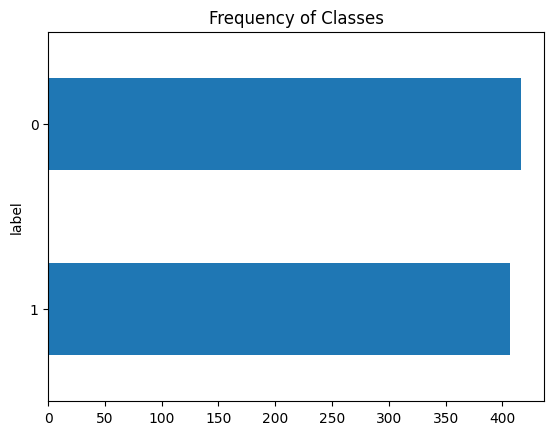

In [5]:
import matplotlib.pyplot as plt
df["label"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

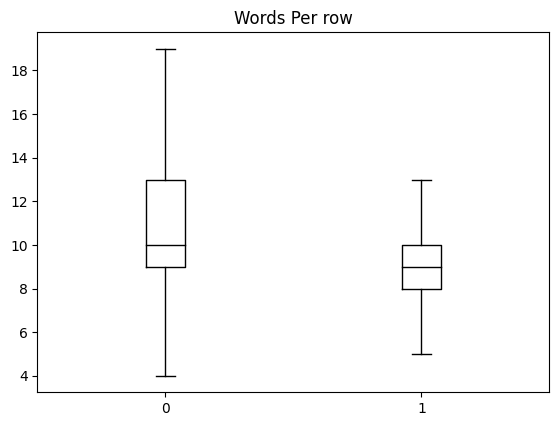

In [6]:
df["Words Per row"] = df["text"].str.split().apply(len)
df.boxplot("Words Per row", by="label", grid=False, showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [7]:
from transformers import AutoModel
import torch
model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

In [8]:
device

device(type='cuda')

In [9]:
from transformers import DistilBertTokenizer
tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [10]:
def tokenize(batch):
  texts = [str(text) for text in batch["text"]]
  tokenized_inputs = tokenizer(texts, padding=True, truncation=True)

  # Add the labels to the tokenized inputs
  tokenized_inputs["labels"] = batch["label"] # Assuming your labels column is named 'label'
  return tokenized_inputs

In [11]:
ds_encoded = ds.map(tokenize, batched=True, batch_size=None)

In [12]:
ds_encoded

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 823
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 46
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 46
    })
})

In [13]:
ds_encoded["train"].column_names

['input_ids', 'attention_mask', 'labels']

In [14]:
ds_encoded.set_format("torch",columns=["input_ids", "attention_mask", "labels"])

In [15]:
from transformers import AutoModelForSequenceClassification
num_labels = 2
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels) .to(device))


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
from sklearn.metrics import accuracy_score, f1_score
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average="weighted")
  acc = accuracy_score(labels, preds)
  return {"accuracy": acc, "f1": f1}

In [17]:
from huggingface_hub import notebook_login
notebook_login()

In [18]:
!pip install transformers[torch]

In [20]:
# !pip install accelerate -U

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.9/330.9 kB 11.2 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.34.2
    Uninstalling accelerate-0.34.2:
      Successfully uninstalled accelerate-0.34.2


In [19]:
from transformers import Trainer, TrainingArguments
batch_size = 64
logging_steps = len(ds_encoded["train"]) // batch_size
model_name = f"{model_ckpt}_finetuned_code_text_classifier"
training_args = TrainingArguments(output_dir=model_name, num_train_epochs=2,
                learning_rate=2e-5, per_device_train_batch_size=batch_size,
                per_device_eval_batch_size=batch_size,
                weight_decay=0.01, evaluation_strategy="epoch",#eval_strategy
                disable_tqdm=False, logging_steps=logging_steps,
                push_to_hub=True, log_level="error")


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [20]:
from transformers import Trainer
trainer = Trainer(model=model, args=training_args,
compute_metrics=compute_metrics,
train_dataset=ds_encoded["train"],
eval_dataset=ds_encoded["validation"],
tokenizer=tokenizer)
trainer.train();

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.531600,0.280714,1.000000,1.000000
2,0.247100,0.156806,1.000000,1.000000


In [35]:
preds_output = trainer.predict(ds_encoded["validation"])
preds_output

PredictionOutput(predictions=array([[ 1.2676307 , -0.80270386],
       [-0.71177804,  0.80259365],
       [ 1.250547  , -0.7852589 ],
       [-0.7688325 ,  0.7250704 ],
       [-0.7175938 ,  0.9319026 ],
       [ 1.1977881 , -0.811436  ],
       [ 1.1205407 , -0.8166737 ],
       [ 1.23234   , -0.77629614],
       [-0.68128747,  0.8854601 ],
       [ 1.2189701 , -0.872706  ],
       [-0.72153014,  0.9330698 ],
       [-0.6925828 ,  0.91932774],
       [ 1.2569956 , -0.7784067 ],
       [ 1.0217745 , -0.67465055],
       [-0.7231152 ,  0.7941044 ],
       [ 0.95677006, -0.70295876],
       [ 1.216209  , -0.7739457 ],
       [ 1.2358971 , -0.7990855 ],
       [-0.68558675,  0.9053963 ],
       [ 1.1646366 , -0.8003716 ],
       [ 1.1775914 , -0.81915265],
       [ 1.2644094 , -0.80593854],
       [-0.67319477,  0.9301688 ],
       [-0.7035965 ,  0.927061  ],
       [ 1.1141068 , -0.7399507 ],
       [ 1.2709229 , -0.77762204],
       [-0.6252542 ,  0.6762553 ],
       [ 1.1969942 , -0.79

In [38]:
import numpy as np
labels = ds["validation"].features["label"].names
y_preds = np.argmax(preds_output.predictions, axis=1)
y_preds

array([0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1,
       0, 0])

In [33]:
import numpy as np
y_valid = np.array(ds_encoded["validation"]["labels"])
y_valid.shape

(46,)

In [23]:
preds_output.metrics

{'test_loss': 0.15680555999279022,
 'test_accuracy': 1.0,
 'test_f1': 1.0,
 'test_runtime': 0.0878,
 'test_samples_per_second': 523.767,
 'test_steps_per_second': 11.386}

## Deploy on HuggingFace

In [39]:
trainer.push_to_hub(commit_message="Training completed!")

CommitInfo(commit_url='https://huggingface.co/AZIIIIIIIIZ/distilbert-base-uncased_finetuned_code_text_classifier/commit/3178028b09e9d1e966a310b3af9dfe78f4224912', commit_message='Training completed!', commit_description='', oid='3178028b09e9d1e966a310b3af9dfe78f4224912', pr_url=None, pr_revision=None, pr_num=None)

In [40]:
from transformers import pipeline
# Change `transformersbook` to your Hub username
model_id = "AZIIIIIIIIZ/distilbert-base-uncased_finetuned_code_text_classifier"
classifier = pipeline("text-classification", model=model_id)

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.25k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [41]:
custom_tweet = "I saw a movie today and it was really good."
preds = classifier(custom_tweet, return_all_scores=True)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


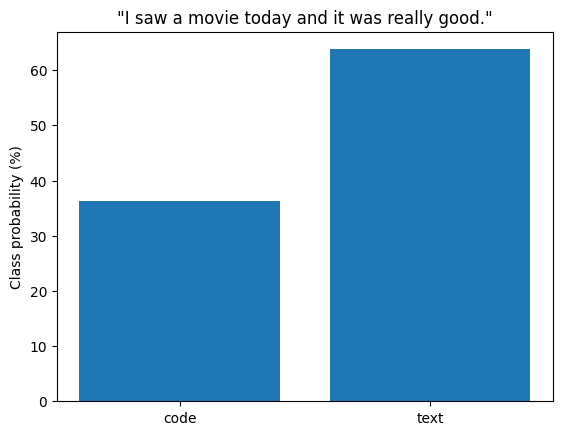

In [42]:
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100 * preds_df["score"], color='C0')
plt.title(f'"{custom_tweet}"')
plt.ylabel("Class probability (%)")
plt.show()
